In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Build your own convolutional neural network using pytorch

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os
import pandas as pd
from PIL import Image
from glob import glob

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = NeuralNetwork(3)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [ ]:
# Transformations
transforms = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Dog_X_ray/Dog_heart/Train', transform=transforms)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Dog_X_ray/Dog_heart/Valid', transform=transforms)

class CustomImageDatasetLoader(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(img_path)
        return image, filename

# Load the test dataset
test_dataset = CustomImageDatasetLoader(root_dir='/content/drive/MyDrive/Dog_X_ray/Test', transform=transforms)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save if the validation loss is the best.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

Epoch [1/50], Train Loss: 1.0364, Val Loss: 1.0236
Epoch [2/50], Train Loss: 0.9953, Val Loss: 0.9912
Epoch [3/50], Train Loss: 0.9680, Val Loss: 0.9473
Epoch [4/50], Train Loss: 0.9161, Val Loss: 0.8760
Epoch [5/50], Train Loss: 0.8621, Val Loss: 0.8367
Epoch [6/50], Train Loss: 0.8267, Val Loss: 0.8129
Epoch [7/50], Train Loss: 0.7763, Val Loss: 0.7763
Epoch [8/50], Train Loss: 0.7644, Val Loss: 0.7300
Epoch [9/50], Train Loss: 0.7298, Val Loss: 0.6820
Epoch [10/50], Train Loss: 0.7043, Val Loss: 0.6904
Epoch [11/50], Train Loss: 0.6734, Val Loss: 0.6399
Epoch [12/50], Train Loss: 0.6528, Val Loss: 0.6298
Epoch [13/50], Train Loss: 0.6333, Val Loss: 0.6073
Epoch [14/50], Train Loss: 0.6011, Val Loss: 0.6088
Epoch [15/50], Train Loss: 0.6139, Val Loss: 0.5826
Epoch [16/50], Train Loss: 0.5605, Val Loss: 0.6208
Epoch [17/50], Train Loss: 0.5424, Val Loss: 0.6150
Epoch [18/50], Train Loss: 0.5040, Val Loss: 0.6013
Epoch [19/50], Train Loss: 0.4957, Val Loss: 0.6271
Epoch [20/50], Train 

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

test_predictions = []
image_paths = []
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

# Predictions to a CSV file
def save_predictions_to_csv(predictions, filenames, filename):
    df = pd.DataFrame(list(zip(filenames, predictions)))
    df.to_csv(filename, index=False, header=False)

save_predictions_to_csv(test_predictions, image_paths, 'project_test_predictions.csv')

# 3. Evaluate your model using the developed software

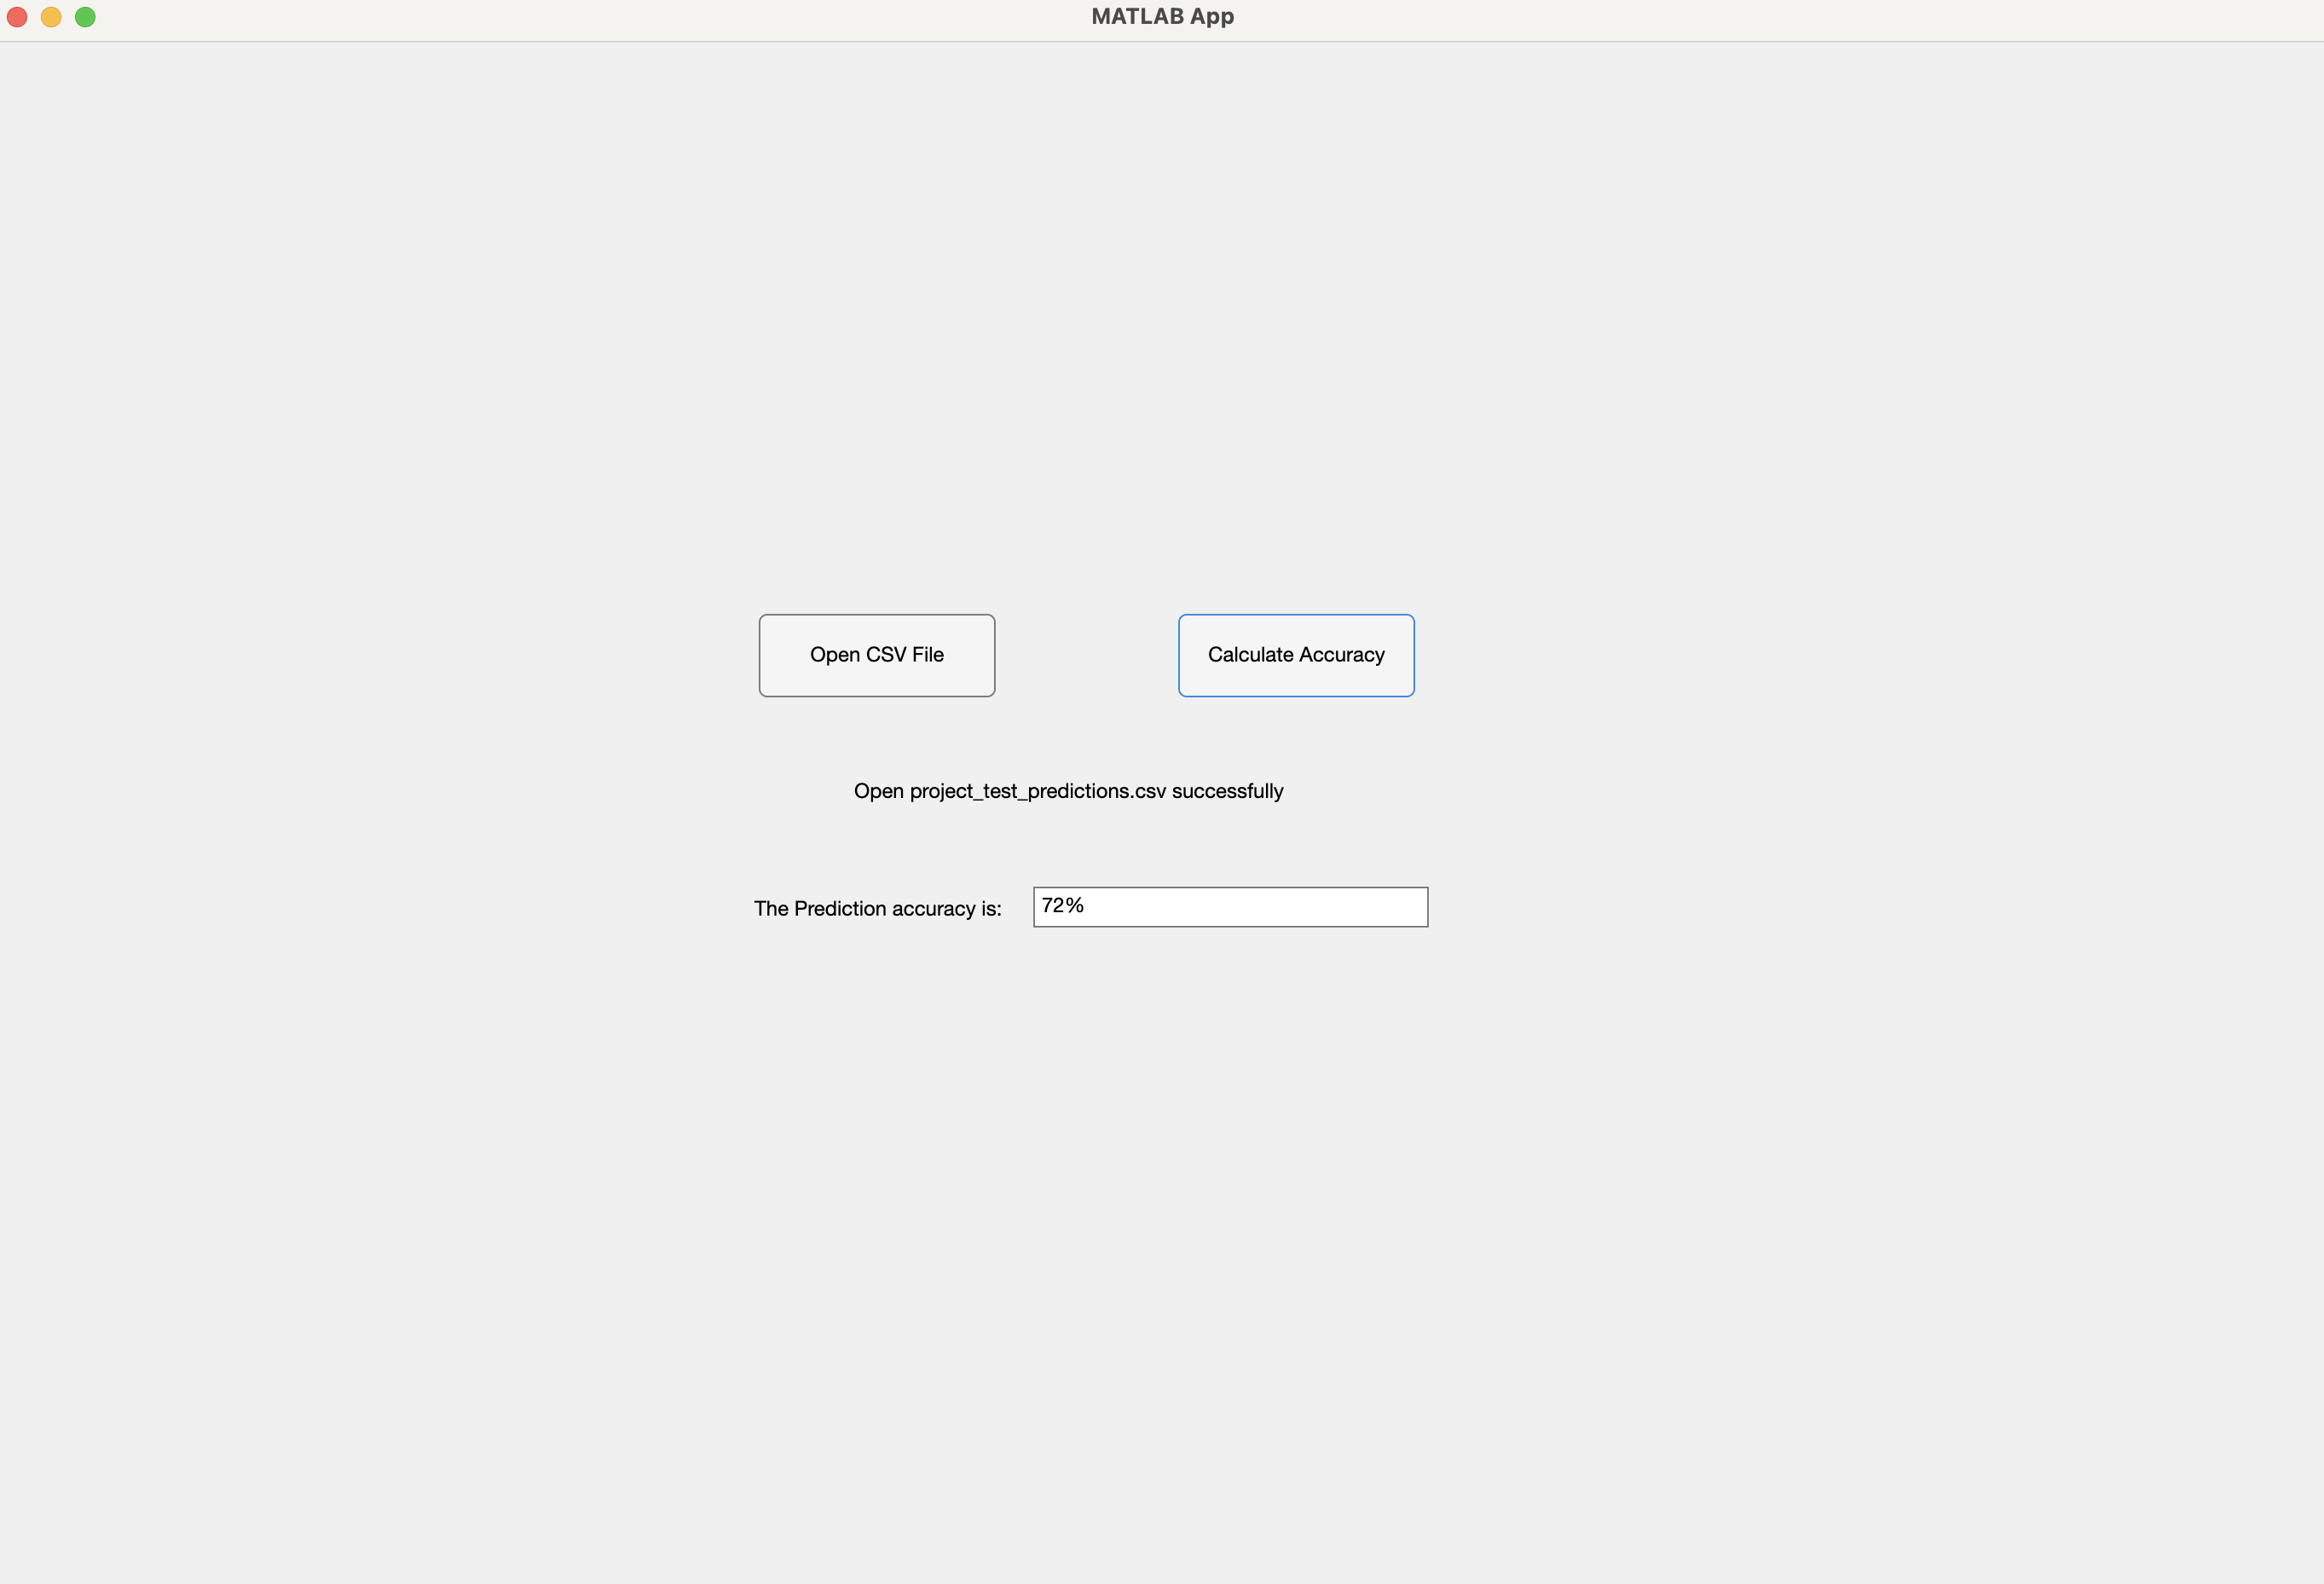

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 70%

When comparing model's performance with VGG16, it's important to highlight both the quantitative and qualitative aspects.

### Comparison of Model Performance

**Model Accuracy**:
- **Custom Model (Custom CNN)**: 72%
- **VGG16**: 74.8%
- **Minimum Requirement**: 70%

**Observations**:
1. **Meets Requirements**:
   - My custom model achieves an accuracy of 72%, which is above the minimum requirement of 70%. This demonstrates that the custom model is capable of performing the task to a satisfactory level.
   
2. **Performance Comparison**:
   - While VGG16 has a slightly higher accuracy (74.8%), the difference is relatively small (2.8% higher than my model). This indicates that  custom model is competitive with the VGG16 architecture.

3. **Model Complexity and Efficiency**:
   - **VGG16**: A very deep model with 16 layers, leading to a higher parameter count and potentially longer training times. This model is well-suited for large and complex datasets but requires significant computational resources.
   - **Custom CNN Model**: A simpler architecture with fewer layers, making it more computationally efficient. This model is likely faster to train and less prone to overfitting due to fewer parameters.

4. **Resource Utilization**:
   - In case of computational resources or time are constraints, this custom model provides a more efficient alternative with comparable performance.

5. **Potential for Improvement**:
   - With some fine-tuning and optimization (e.g., adjusting learning rates, experimenting with data augmentation, or adding more regularization), this model might be able to close the performance gap further VGG16.

### Conclusion

This custom model meets the minimum requirement with a solid accuracy of 72%. Although VGG16 achieves a slightly higher accuracy of 74.8%, my model's performance is competitive. Additionally, this model offers advantages in terms of simplicity and computational efficiency, making it a viable choice for scenarios where resources are constrained. With further optimization, this model has the potential to achieve even better performance.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Paper Link: https://www.researchgate.net/publication/382077522_Assessing_Cardiomegaly_in_Dogs_Using_a_Simple_CNN_Model

Github Weight Link: https://github.com/NikhilDeekonda77/Dog_Cardiomegaly_Assessment/blob/main/best_model.pt


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 70 % -->10 points
     < 50 % -->0 points
     >= 50 % & < 70% --> 0.5 point/percent
     

(6). Discussion - 10 points